In [72]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
import keras.backend as k
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2

In [13]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
data=pd.read_csv('gdrive/My Drive/icml_face_data.csv')

In [16]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [17]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [18]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [19]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [20]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [21]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [22]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

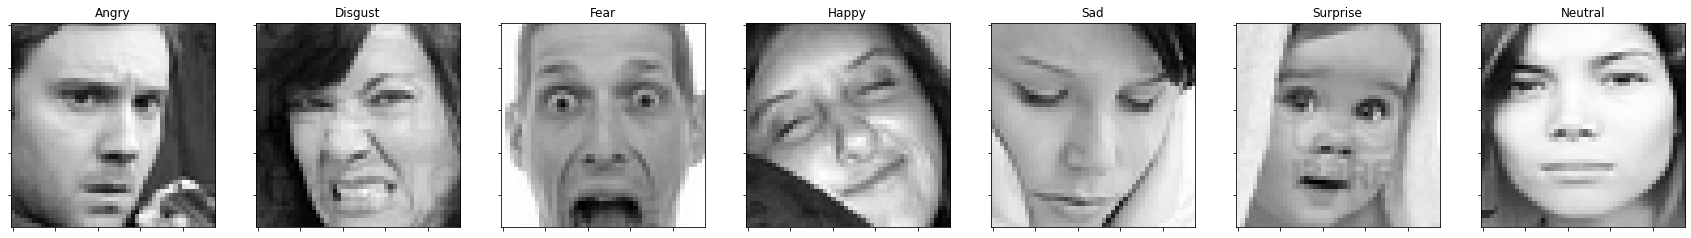

In [23]:
plot_all_emotions()

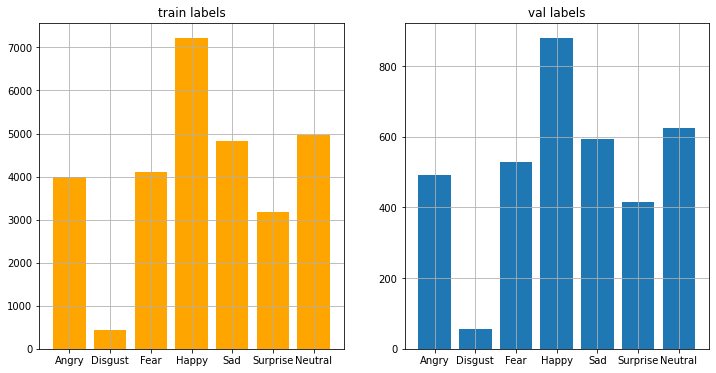

In [24]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [25]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [26]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [27]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [28]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [30]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 103s 224ms/step - loss: 0.2738 - accuracy: 0.2911 - val_loss: 1.6239 - val_accuracy: 0.3795
Epoch 2/12
449/449 [==============================] - 98s 219ms/step - loss: 0.2372 - accuracy: 0.4053 - val_loss: 1.5233 - val_accuracy: 0.4260
Epoch 3/12
449/449 [==============================] - 96s 214ms/step - loss: 0.2151 - accuracy: 0.4670 - val_loss: 1.4426 - val_accuracy: 0.4700
Epoch 4/12
449/449 [==============================] - 99s 219ms/step - loss: 0.2015 - accuracy: 0.5004 - val_loss: 1.4332 - val_accuracy: 0.4778
Epoch 5/12
449/449 [==============================] - 99s 220ms/step - loss: 0.1911 - accuracy: 0.5262 - val_loss: 1.3137 - val_accuracy: 0.5132
Epoch 6/12
449/449 [==============================] - 96s 213ms/step - loss: 0.1831 - accuracy: 0.5502 - val_loss: 1.3105 - val_accuracy: 0.5222
Epoch 7/12
449/449 [==============================] - 98s 218ms/step - loss: 0.1760 - accuracy: 0.5688 - val_loss: 1.3479 - val_a

In [31]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 4s 31ms/step - loss: 1.2847 - accuracy: 0.5408
test caccuracy: 0.5408191680908203


In [32]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 4s 31ms/step


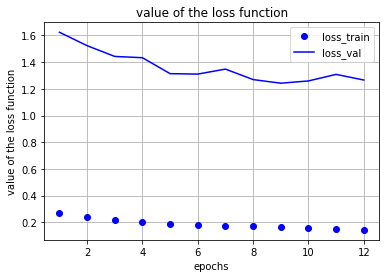

In [33]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

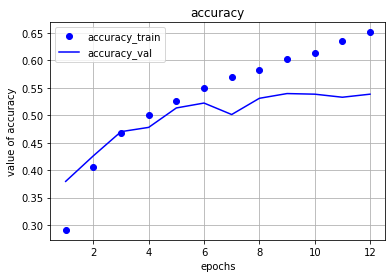

In [34]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

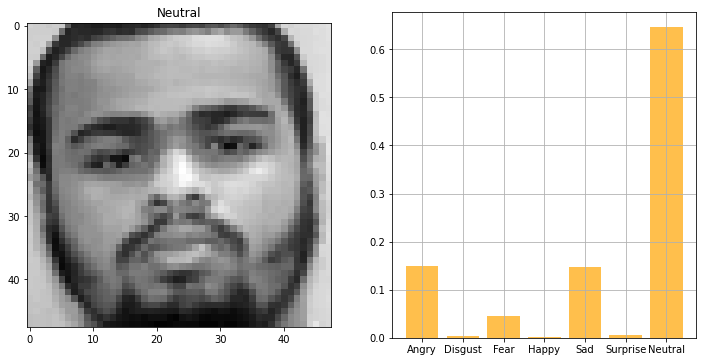

In [35]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

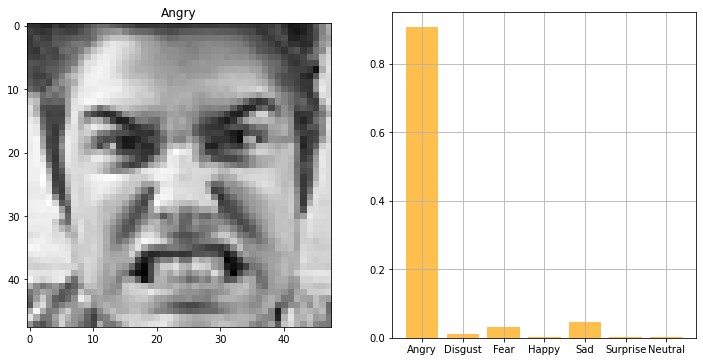

In [36]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

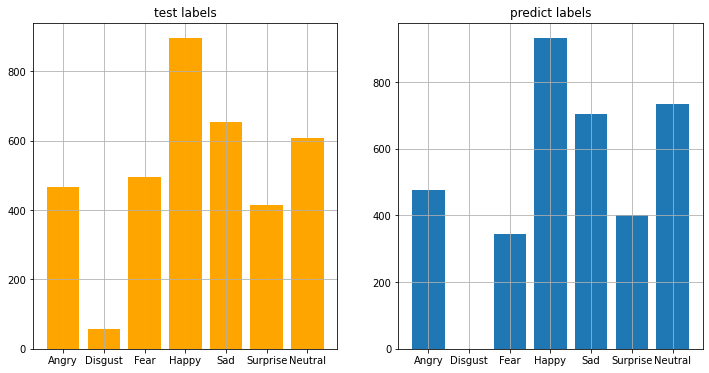

In [37]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

In [41]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

1/1 [==============================] - 0s 22ms/step


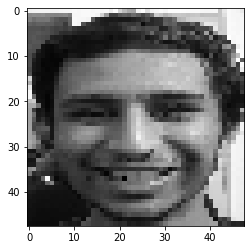

[1.1153350e-03 8.2680810e-07 4.3504644e-04 9.5825309e-01 4.4863187e-03
 1.4021891e-04 3.5569150e-02]


In [66]:
img = image.load_img('omhappy.jpeg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [67]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

happy


1/1 [==============================] - 0s 25ms/step


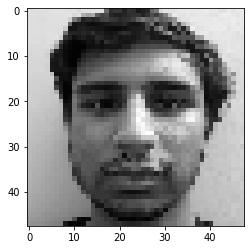

[0.13756235 0.00033487 0.1332714  0.22110435 0.11006786 0.17110656
 0.2265526 ]


In [68]:
img = image.load_img('om2.jpeg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [69]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

neutral


1/1 [==============================] - 0s 24ms/step


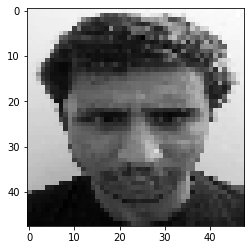

[0.78341895 0.00414016 0.03402165 0.0289499  0.10661311 0.00206811
 0.04078804]


In [70]:
img = image.load_img('omangry.jpeg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [71]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

angry


1/1 [==============================] - 0s 66ms/step


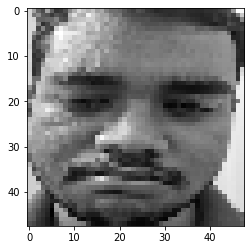

[0.04239327 0.00093712 0.127356   0.00827391 0.59430003 0.00072224
 0.2260174 ]


In [75]:
img = image.load_img('sandeepsad.jpeg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [76]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

sad
